In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [44]:
def getSymbolReport(symbol:str) -> str:
    """
    Get required financial report for the desired symbol.
    symbol: Symbol
    """
    ticker = yf.Ticker(symbol)
    info_dict = ticker.get_info()
    news_list = ticker.get_news()
    institutional_holders = ticker.get_institutional_holders()
    mutualfund_holders = ticker.get_mutualfund_holders()   
    ann_income_stmt = ticker.get_income_stmt()
    qua_income_stmt = ticker.quarterly_income_stmt
    ann_balance_sheet = ticker.get_balance_sheet()
    qua_balance_sheet = ticker.quarterly_balance_sheet
    data = 

    def getCompanyInfo(info_dict:dict) -> str: 

        sel_fields = ['longName','website','sector','industry','longBusinessSummary','fullTimeEmployees','companyOfficers']
        s = f"## **{info_dict['longName']}**<br>\n"
        for field in sel_fields:
            if field == 'longBusinessSummary':
                s += f"\n### **Business Summary**<br>\n{info_dict[field]}"
                continue
            elif field == 'fullTimeEmployees':
                s += "\n### **Employee Details**<br>\n"
            elif field == 'companyOfficers':
                s += 'majorEmployees:<br>\n'
                for officer in info_dict['companyOfficers']:
                    s += f"- {officer['name']}: {officer['title']}<br>\n"
                continue
            s += f"{field}: " + str(info_dict[field]) + "<br>\n"
        return s
    
    def getCompanyNews(news_list:list) -> str:

        sel_fields = ['title','link','publisher']
        s = f"### **Recent Company News**<br>\n"
        for news in news_list:
            for field in sel_fields:
                s += f"{field}: " + f"{news[field]}<br>\n"
            s += "<br>\n"
        return s
    
    def getInvestorData(df1:pd.DataFrame, df2:pd.DataFrame) -> str:

        # Institutional Holders and Percentage Holding
        plt.figure(figsize=(15,5))
        plt.title('Institutional Holders and Percentage Holding')
        plt.pie(df1['Shares'],normalize=True,labels=df1['Holder'])
        plt.pie(df1['Shares'],normalize=True,labels=round((df1['Shares']/df1['Shares'].sum())*100,3),labeldistance=0.5,rotatelabels=True)
        plt.savefig('./ReportMedia/Institutional_Holders_and_Percentage_Holding.png')
        
        # Mutual_Fund_Holders_and_Percentage_Holding
        plt.figure(figsize=(15,5))
        plt.title('Mutual Fund Holders and Percentage Holding')
        plt.pie(df2['Shares'],normalize=True,labels=df2['Holder'])
        plt.pie(df2['Shares'],normalize=True,labels=round((df2['Shares']/df2['Shares'].sum())*100,3),labeldistance=0.5,rotatelabels=True)
        plt.savefig('./ReportMedia/Mutual_Fund_Holders_and_Percentage_Holding.png')

        s = "### **Investor Data**<br>\n![Institutional Holders and Percentage Holding](./ReportMedia/Institutional_Holders_and_Percentage_Holding.png)<br>\n![Mutual_Fund_Holders_and_Percentage_Holding](./ReportMedia/Mutual_Fund_Holders_and_Percentage_Holding.png)<br>\n"
        return s
    
    def getFinancials(df1:dict, df2:pd.DataFrame, df3:pd.DataFrame, df4:pd.DataFrame, df5:pd.DataFrame):
        sel_fields1 = ['totalRevenue','totalDebt','totalCash','enterpriseValue','bookValue','marketCap','currentRatio','quickRatio'] # 'debtToEquity','dividendRate','dividendYield','fiveYearAvgDividendYield','earningsGrowth','earningsQuarterlyGrowth','enterpriseToEbitda','enterpriseToRevenue','payoutRatio','priceToBook','profitMargins','returnOnAssets','returnOnEquity','revenueGrowth','revenuePerShare','totalCashPerShare']
        sel_fields2 = ['EBITDA','EBIT','InterestExpense','InterestIncome','TotalExpenses','NetIncome','TotalRevenue','GrossProfit','BasicEPS','ResearchAndDevelopment']
        s = '### **Latest Financials**<br>\n#### General Financials<br>\n'
        for field in sel_fields1:
            if field == 'currentRatio':
                s += '#### Liquidity Ratios<br>\n'
                ann_current_ratio = 0
                qua_current_ratio = 0
                if 'CurrentAssets' in df4.index and 'CurrentLiabilities' in df4.index:
                    ann_current_ratio = 1                    
                if 'Current Assets' in df5.index and 'Current Liabilities' in df5.index:
                    qua_current_ratio = 1
                
                if ann_current_ratio and qua_current_ratio:
                    fig,ax = plt.subplots(1,2,sharey=True, figsize=(10,5))
                    ax[0].set_title('Annual Current Ratio')
                    ax[0].plot(df4.columns, np.array(df4.loc['CurrentAssets'])/np.array(df4.loc['CurrentLiabilities']))
                    ax[0].set_xlabel('Time Instance')
                    ax[0].set_ylabel('Current Ratio')

                    fig.suptitle('Current Ratio')
                    ax[1].set_title('Quarterly Current Ratio')
                    ax[1].plot(df5.columns, np.array(df5.loc['Current Assets'])/np.array(df5.loc['Current Liabilities']))
                    ax[1].set_xlabel('Time Instance')
                    plt.savefig('./ReportMedia/Current_Ratio.png')
                    s += "![Current Ratio](./ReportMedia/Current_Ratio.png)<br>\n"

                elif ann_current_ratio:
                    plt.figure(figsize=(10,5))
                    plt.title('Annual Current Ratio')
                    plt.plot(df4.columns, np.array(df4.loc['CurrentAssets'])/np.array(df4.loc['CurrentLiabilities']))
                    plt.xlabel('Time Instance')
                    plt.ylabel('Current Ratio')
                    plt.savefig('./ReportMedia/Current_Ratio.png')
                    s += "![Current Ratio](./ReportMedia/Current_Ratio.png)<br>\n"
                
                elif qua_current_ratio:
                    plt.figure(figsize=(10,5))
                    plt.title('Quarterly Current Ratio')
                    plt.plot(df5.columns, np.array(df5.loc['Current Assets'])/np.array(df5.loc['Current Liabilities']))
                    plt.xlabel('Time Instance')
                    plt.ylabel('Current Ratio')
                    plt.savefig('./ReportMedia/Current_Ratio.png')
                    s += "![Current Ratio](./ReportMedia/Current_Ratio.png)<br>\n"
                
                else:
                    s += f'Historical Data Unavailable. Recent Current Ratio: {df1['currentRatio']}<br>\n'
            
            elif field == 'quickRatio':
                fields = ['CurrentAssets', 'CurrentLiabilities','Inventory','PrepaidAssets','OtherCurrentAssets']
                fields1 = ['Current Assets', 'Current Liabilities','Inventory','Prepaid Assets','Other Current Assets']
                ann_quick_ratio = []
                qua_quick_ratio = []
                for index,i in enumerate(fields):
                    if i in df4.index:
                        ann_quick_ratio.append(index)
                for index,i in enumerate(fields1):
                    if i in df5.index:
                        qua_quick_ratio.append(index)
                
                if len(ann_quick_ratio) == 5  and len(qua_quick_ratio) == 5:
                    fig,ax = plt.subplots(1,2,sharey=True, figsize=(10,5))
                    fig.suptitle('Quick Ratio')
                    ax[0].set_title('Annual Quick Ratio')
                    ax[0].plot(df4.columns, (np.array(df4.loc['CurrentAssets']) - np.array(df4.loc['Inventory']) - np.array(df4.loc['PrepaidAssets']) - np.array(df4.loc['OtherCurrentAssets']))/np.array(df4.loc['CurrentLiabilities']))
                    ax[0].set_xlabel('Time Instance')
                    ax[0].set_ylabel('Quick Ratio')

                    ax[1].set_title('Quarterly Quick Ratio')
                    ax[1].plot(df5.columns, (np.array(df5.loc['Current Assets']) - np.array(df5.loc['Inventory']) - np.array(df5.loc['Prepaid Assets']) - np.array(df5.loc['Other Current Assets']))/np.array(df5.loc['Current Liabilities']))
                    ax[1].set_xlabel('Time Instance')
                    ax[1].set_ylabel('Quick Ratio')
                    plt.savefig('./ReportMedia/Quick_Ratio.png')
                    s += "![Quick Ratio](./ReportMedia/Quick_Ratio.png)<br>\n"

                elif ([i in ann_quick_ratio for i in [0,1,2,4]] == 4*[True]) and ([i in qua_quick_ratio for i in [0,1,2,4]] == 4*[True]):
                    fig,ax = plt.subplots(1,2,sharey=True, figsize=(10,5))
                    fig.suptitle('Quick Ratio')
                    ax[0].set_title('Annual Quick Ratio')
                    ax[0].plot(df4.columns, (np.array(df4.loc['CurrentAssets']) - np.array(df4.loc['Inventory']) - np.array(df4.loc['OtherCurrentAssets']))/np.array(df4.loc['CurrentLiabilities']))
                    ax[0].set_xlabel('Time Instance')
                    ax[0].set_ylabel('Quick Ratio')

                    ax[1].set_title('Quarterly Quick Ratio')
                    ax[1].plot(df5.columns, (np.array(df5.loc['Current Assets']) - np.array(df5.loc['Inventory']) - np.array(df5.loc['Other Current Assets']))/np.array(df5.loc['Current Liabilities']))
                    ax[1].set_xlabel('Time Instance')
                    ax[1].set_ylabel('Quick Ratio')
                    plt.savefig('./ReportMedia/Quick_Ratio.png')
                    s += "![Quick Ratio](./ReportMedia/Quick_Ratio.png)<br>\n"
                
                elif ([i in ann_quick_ratio for i in [0,1,3,4]] == 4*[True]) and ([i in qua_quick_ratio for i in [0,1,3,4]] == 4*[True]):
                    fig,ax = plt.subplots(1,2,sharey=True, figsize=(10,5))
                    fig.suptitle('Quick Ratio')
                    ax[0].set_title('Annual Quick Ratio')
                    ax[0].plot(df4.columns, (np.array(df4.loc['CurrentAssets']) - np.array(df4.loc['PrepaidAssets']) - np.array(df4.loc['OtherCurrentAssets']))/np.array(df4.loc['CurrentLiabilities']))
                    ax[0].set_xlabel('Time Instance')
                    ax[0].set_ylabel('Quick Ratio')

                    ax[1].set_title('Quarterly Quick Ratio')
                    ax[1].plot(df5.columns, (np.array(df5.loc['Current Assets']) - np.array(df5.loc['Prepaid Assets']) - np.array(df5.loc['Other Current Assets']))/np.array(df5.loc['Current Liabilities']))
                    ax[1].set_xlabel('Time Instance')
                    ax[1].set_ylabel('Quick Ratio')
                    plt.savefig('./ReportMedia/Quick_Ratio.png')
                    s += "![Quick Ratio](./ReportMedia/Quick_Ratio.png)<br>\n"

                elif ([i in ann_quick_ratio for i in [0,1,4]] == 4*[True]) and ([i in qua_quick_ratio for i in [0,1,4]] == 4*[True]):
                    fig,ax = plt.subplots(1,2,sharey=True, figsize=(10,5))
                    fig.suptitle('Quick Ratio')
                    ax[0].set_title('Annual Quick Ratio')
                    ax[0].plot(df4.columns, (np.array(df4.loc['CurrentAssets']) - np.array(df4.loc['OtherCurrentAssets']))/np.array(df4.loc['CurrentLiabilities']))
                    ax[0].set_xlabel('Time Instance')
                    ax[0].set_ylabel('Quick Ratio')

                    ax[1].set_title('Quarterly Quick Ratio')
                    ax[1].plot(df5.columns, (np.array(df5.loc['Current Assets']) - np.array(df5.loc['Other Current Assets']))/np.array(df5.loc['Current Liabilities']))
                    ax[1].set_xlabel('Time Instance')
                    ax[1].set_ylabel('Quick Ratio')
                    plt.savefig('./ReportMedia/Quick_Ratio.png')
                    s += "![Quick Ratio](./ReportMedia/Quick_Ratio.png)<br>\n"
                
                else:
                    s += f'Historical Data Unavailable. Recent Quick Ratio: {df1['quickRatio']}<br>\n'
            elif field == 'bookValue':
                s += f"{field}PerShare: " + f"{df1[field]}<br>\n"
            elif field == 'enterpriseValue':
                s += f"{field}: " + f"{df1[field] if df1[field] > 0 else df1['marketCap'] + df1['totalDebt'] - df5.loc['Cash And Cash Equivalents'].iloc[0]}<br>\n"
            else:
                s += f"{field}: " + f"{df1[field]}<br>\n"
        return s

    return getCompanyInfo(info_dict = info_dict) + getCompanyNews(news_list = news_list) + getInvestorData(df1 = institutional_holders, df2 = mutualfund_holders) + getFinancials(df1 = info_dict, df2 = ann_income_stmt, df3 = qua_income_stmt, df4 = ann_balance_sheet, df5 = qua_balance_sheet)

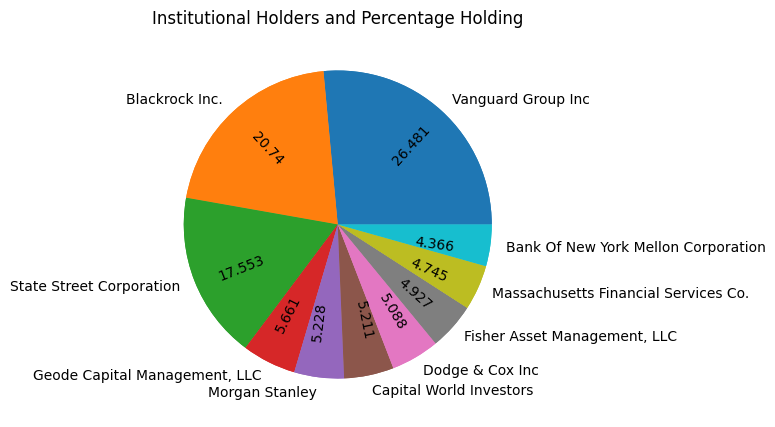

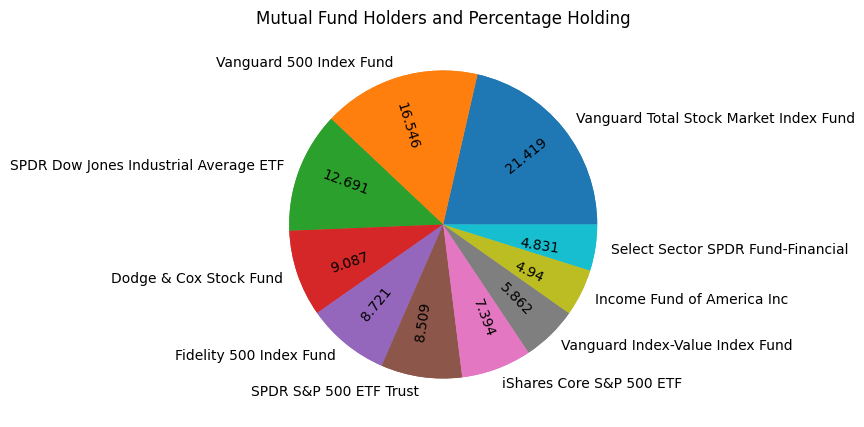

In [51]:
symbol = 'GS'
with open('Report.md','w') as file:
    file.write(getSymbolReport(symbol = symbol))
file.close()

## **The Goldman Sachs Group, Inc.**<br>
longName: The Goldman Sachs Group, Inc.<br>
website: https://www.goldmansachs.com<br>
sector: Financial Services<br>
industry: Capital Markets<br>

### **Business Summary**<br>
The Goldman Sachs Group, Inc., a financial institution, provides a range of financial services for corporations, financial institutions, governments, and individuals worldwide. It operates through Global Banking & Markets, Asset & Wealth Management, and Platform Solutions segments. The Global Banking & Markets segment provides financial advisory services, including strategic advisory assignments related to mergers and acquisitions, divestitures, corporate defense activities, restructurings, and spin-offs; and relationship lending, and acquisition financing, as well as secured lending, through structured credit and asset-backed lending and involved in resale agreements. This segment also offers client execution activities for cash and derivative instruments; credit and interest rate products; and provision of mortgages, currencies, commodities, and equities related products, as well as underwriting services. The Asset & Wealth Management segment manages assets across various classes, including equity, fixed income, hedge funds, credit funds, private equity, real estate, currencies, and commodities; and provides customized investment advisory solutions, wealth advisory services, personalized financial planning, and private banking services, as well as invests in corporate equity, credit, real estate, and infrastructure assets. The Platform Solutions segment offers credit cards and point-of-sale financing for purchase of goods or services. This segment also provides cash management services, such as deposit-taking and payment solutions for corporate and institutional clients. The Goldman Sachs Group, Inc. was founded in 1869 and is headquartered in New York, New York.
### **Employee Details**<br>
fullTimeEmployees: 45300<br>
majorEmployees:<br>
- Mr. David  Solomon: Chairman & CEO<br>
- Mr. John E. Waldron: President & COO<br>
- Mr. Denis P. Coleman III: Chief Financial Officer<br>
- Ms. Kathryn H. Ruemmler: Chief Legal Officer, Secretary & General Counsel<br>
- Mr. Philip R. Berlinski: Global Treasurer<br>
- Mr. J. D. Gardner: Director<br>
- Ms. Sheara J. Fredman: Controller & Chief Accounting Officer<br>
- F. X. De Mallmann: Chair of Investment Banking<br>
- Mr. Atte  Lahtiranta: Partner & Chief Technology Officer<br>
- Mr. Marco  Argenti: Partner & Chief Information Officer<br>
### **Recent Company News**<br>
title: Parexel Appoints Susan R. Salka to Board of Directors<br>
link: https://finance.yahoo.com/news/parexel-appoints-susan-r-salka-140000158.html<br>
publisher: GlobeNewswire<br>
<br>
title: Is Goldman Sachs ActiveBeta U.S. Small Cap Equity ETF (GSSC) a Strong ETF Right Now?<br>
link: https://finance.yahoo.com/news/goldman-sachs-activebeta-u-small-112007929.html<br>
publisher: Zacks<br>
<br>
title: Goldman�s Jim Esposito to retire after nearly 3 decades: �Sometimes you have to pause to acknowledge the chapters you�ve written�<br>
link: https://finance.yahoo.com/news/goldman-jim-esposito-retire-nearly-174317211.html<br>
publisher: Fortune<br>
<br>
title: Baltimore Orioles sale to Carlyle's co-founder David Rubenstein for $1.725 billion nearly done: source<br>
link: https://finance.yahoo.com/news/baltimore-orioles-sale-to-carlyles-co-founder-david-rubenstein-for-1725-billion-nearly-done-source-132924998.html<br>
publisher: Yahoo Finance<br>
<br>
title: Korea's GS E&C hires Goldman Sachs for 1 bln euro sale of Spain's Inima, Expansion says<br>
link: https://finance.yahoo.com/news/koreas-gs-e-c-hires-075052789.html<br>
publisher: Reuters<br>
<br>
title: Insiders At Goldman Sachs Group Sold US$16m In Stock, Alluding To Potential Weakness<br>
link: https://finance.yahoo.com/news/insiders-goldman-sachs-group-sold-110059052.html<br>
publisher: Simply Wall St.<br>
<br>
title: Goldman Sachs BDC (GSBD) Stock Falls Amid Market Uptick: What Investors Need to Know<br>
link: https://finance.yahoo.com/news/goldman-sachs-bdc-gsbd-stock-230016481.html<br>
publisher: Zacks<br>
<br>
title: Unlocking Profits: Discover The Banking Stocks Riding The Wave Of 2024 Rate Drops<br>
link: https://finance.yahoo.com/news/unlocking-profits-discover-banking-stocks-200126460.html<br>
publisher: Benzinga<br>
<br>
### **Investor Data**<br>
![Institutional Holders and Percentage Holding](./ReportMedia/Institutional_Holders_and_Percentage_Holding.png)<br>
![Mutual_Fund_Holders_and_Percentage_Holding](./ReportMedia/Mutual_Fund_Holders_and_Percentage_Holding.png)<br>
### **Latest Financials**<br>
#### General Financials<br>
totalRevenue: 45226000384<br>
totalDebt: 642000027648<br>
totalCash: 719999991808<br>
enterpriseValue: 69306433536<br>
bookValuePerShare: 19.177<br>
marketCap: 124118228992<br>
#### Liquidity Ratios<br>
Historical Data Unavailable. Recent Current Ratio: 2.876<br>
Historical Data Unavailable. Recent Quick Ratio: 2.041<br>
